In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import warnings
import os
from sklearn.svm import SVC
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Dataset Pre-processing

In [2]:
TASKS = ["climbing","walking", "jumping", "running"]
LABELS = {
    "climbing" : 1,
    "walking" : 2,
    "jumping" : 3,
    "running" : 4
}
SENSORS = ["Accelerometer","Gyroscope"]
WINDOW_LENGTH = 100
dataset_path = "dataset/train/"

In [3]:
data = {}
for sensors in SENSORS:
    data[sensors] = []
for vals in TASKS:
    sub_dirs = [x for x in os.walk(dataset_path + vals)]
    datapoints = sub_dirs[0][1]
    for pts in datapoints:
        for sensors in SENSORS:
            file_path = dataset_path + vals + "/" + pts + "/" +sensors + ".csv"
            df = pd.read_csv(file_path)
            df["Label"] = LABELS[vals]
            data[sensors].append(df)

In [4]:
acc = data["Accelerometer"]
gyro = data["Gyroscope"]
combine = []

In [5]:
for i in range(len(acc)):
    print(acc[i].shape,gyro[i].shape)

(632, 6) (640, 6)
(1034, 6) (1046, 6)
(569, 6) (577, 6)
(8776, 6) (9005, 6)
(1327, 6) (1341, 6)
(2325, 6) (2346, 6)
(3823, 6) (3851, 6)
(3553, 6) (3581, 6)
(1808, 6) (1860, 6)
(4907, 6) (5040, 6)
(2589, 6) (2611, 6)
(1892, 6) (1911, 6)
(1984, 6) (2002, 6)
(2911, 6) (2934, 6)
(1671, 6) (1685, 6)
(1859, 6) (1875, 6)
(5257, 6) (5295, 6)


In [6]:
N = 50
for i in range(len(acc)):
    length = min(acc[i].shape[0],gyro[i].shape[0])
    length = length - length%100
    acc[i] = acc[i][:length]
    gyro[i] = gyro[i][:length]
    acc[i] = acc[i][N:-N]
    gyro[i] = gyro[i][N:-N]

In [7]:
for i in range(len(acc)):
    print(acc[i].shape,gyro[i].shape)
    try:
        acc[i].drop(acc[i][["Timestamp","Milliseconds"]],inplace=True,axis=1)
        gyro[i].drop(gyro[i][["Timestamp","Milliseconds"]],inplace=True,axis=1)
    except:
        pass
    gyro[i] = gyro[i].reset_index(drop=True)
    acc[i] = acc[i].reset_index(drop=True)
    acc[i].columns = ["ACCX","ACCY","ACCZ","OUTPUT"]
    gyro[i].columns = ["GYROX","GYROY","GYROZ","OUTPUT"]
    if(acc[i]['OUTPUT'].equals(gyro[i]["OUTPUT"])):
        acc[i].drop(acc[i][["OUTPUT"]],axis=1,inplace=True)
        df = pd.concat([acc[i], gyro[i]],axis=1)
        combine.append(df)
    else:
        print("Error in merging tables")

(500, 6) (500, 6)
(900, 6) (900, 6)
(400, 6) (400, 6)
(8600, 6) (8600, 6)
(1200, 6) (1200, 6)
(2200, 6) (2200, 6)
(3700, 6) (3700, 6)
(3400, 6) (3400, 6)
(1700, 6) (1700, 6)
(4800, 6) (4800, 6)
(2400, 6) (2400, 6)
(1700, 6) (1700, 6)
(1800, 6) (1800, 6)
(2800, 6) (2800, 6)
(1500, 6) (1500, 6)
(1700, 6) (1700, 6)
(5100, 6) (5100, 6)


In [8]:
for i in range(len(combine)):
    print(combine[i].shape)
combine[0].head()

(500, 7)
(900, 7)
(400, 7)
(8600, 7)
(1200, 7)
(2200, 7)
(3700, 7)
(3400, 7)
(1700, 7)
(4800, 7)
(2400, 7)
(1700, 7)
(1800, 7)
(2800, 7)
(1500, 7)
(1700, 7)
(5100, 7)


,ACCX,ACCY,ACCZ,GYROX,GYROY,GYROZ,OUTPUT
0,1.756760,2.113892,11.440537,-0.561157,-0.518875,-0.407303,1
1,1.507751,2.034882,11.773331,-0.494049,-0.328201,-0.405167,1
2,0.866104,1.812225,11.797272,-0.401382,-0.135376,-0.357239,1
3,0.921173,1.807434,11.916992,-0.281006,0.126678,-0.317825,1
4,1.184540,1.374084,11.656021,-0.176605,0.433472,-0.305038,1


In [9]:

x_data = []
y_data = []
for values in combine:
    i=0
    while(i<= values.shape[0]- WINDOW_LENGTH):
        i = int(i)
        temp = values[i:i+WINDOW_LENGTH]
        temp_input = temp.drop(temp[['OUTPUT']],axis=1)
        temp_output = temp[['OUTPUT']]
        x_data.append(temp_input)
        y_data.append(temp_output.iloc[0])
        i = i + WINDOW_LENGTH/2


In [168]:
dfm = pd.DataFrame()
dfs = pd.DataFrame()
dfmad = pd.DataFrame()
dfavgdiff = pd.DataFrame()
dfmax = pd.DataFrame()
dfmin = pd.DataFrame()

for windows in x_data:
    df_mean = pd.DataFrame(windows.mean()).transpose()
    df_std = pd.DataFrame(windows.std()).transpose()
    df_max = pd.DataFrame(windows.max()).transpose()
    df_med_abs = pd.DataFrame(windows.mad()).transpose()
    df_avg_diff = pd.DataFrame(windows.diff().dropna().div(10).mean()).transpose()
    df_min = pd.DataFrame(windows.min()).transpose()
    dfm = pd.concat([dfm, df_mean])
    dfs = pd.concat([dfs, df_std])
    dfmad = pd.concat([dfmad, df_med_abs])
    dfmax = pd.concat([dfmax, df_max])
    dfmin = pd.concat([dfmin, df_min])
    dfavgdiff = pd.concat([dfavgdiff, df_avg_diff])
    
dfm = dfm.reset_index(drop=True)
dfs = dfs.reset_index(drop=True)
dfmad = dfmad.reset_index(drop=True)
# dfmed = dfmed.reset_index(drop=True)
dfavgdiff = dfavgdiff.reset_index(drop=True)
dfmax = dfmax.reset_index(drop=True)
dfmin = dfmin.reset_index(drop=True)

dfm.columns = [x + "_mean" for x in dfm.columns]
dfs.columns = [x + "_std" for x in dfs.columns]
dfmad.columns = [x + "_mad" for x in dfmad.columns]
dfavgdiff.columns = [x + "_avgdiff" for x in dfavgdiff.columns]
dfmax.columns = [x + "_max" for x in dfmax.columns]
dfmin.columns = [x + "_min" for x in dfmin.columns]
df_featured = dfm.join([dfs, dfmad, dfavgdiff, dfmax, dfmin])
df_featured


,ACCX_mean,ACCY_mean,ACCZ_mean,GYROX_mean,GYROY_mean,GYROZ_mean,ACCX_std,ACCY_std,ACCZ_std,GYROX_std,...,ACCZ_max,GYROX_max,GYROY_max,GYROZ_max,ACCX_min,ACCY_min,ACCZ_min,GYROX_min,GYROY_min,GYROZ_min
0,0.963723,2.141069,10.397290,0.056528,-0.051801,-0.018789,1.203765,0.993857,2.116223,0.344078,...,15.505890,0.874817,0.730682,0.845444,-1.044464,0.332611,6.319336,-0.561157,-1.256042,-1.033676
1,1.169409,1.835089,9.912081,-0.007355,-0.023198,0.130912,1.154653,1.028456,3.127856,0.322936,...,16.533005,1.170959,1.189804,0.911499,-1.140228,0.165009,2.285111,-0.552643,-1.256042,-0.787598
2,1.253206,2.089235,9.759905,0.016421,-0.032253,0.085212,1.042778,1.085515,3.509643,0.333383,...,16.533005,1.170959,1.189804,0.911499,-1.140228,0.165009,2.285111,-0.486603,-0.870407,-0.567093
3,1.850511,1.875888,9.671128,-0.036234,-0.081693,-0.056223,0.841748,0.799003,2.608182,0.359893,...,16.102050,0.591446,0.858505,0.572739,0.404037,0.148254,2.481430,-0.963837,-1.160171,-0.459503
4,1.809689,1.796639,9.689301,-0.052831,-0.014037,-0.023242,0.844593,0.616359,1.635224,0.327706,...,14.526672,0.508362,0.858505,0.276596,0.099960,0.148254,6.034439,-0.963837,-1.160171,-0.648056
5,1.607667,1.862096,9.418541,-0.015334,0.021734,-0.035535,0.589480,0.491149,1.531068,0.170649,...,13.274490,0.448700,0.789261,0.276596,0.099960,0.399643,6.625793,-0.513229,-0.450699,-0.662964
6,1.455109,1.794197,9.492952,0.008443,0.043509,-0.001201,0.482742,0.556662,1.591669,0.160961,...,14.818756,0.448700,1.004456,0.233994,0.200516,0.255997,7.346451,-0.489792,-0.552963,-0.662964
7,1.501772,1.692563,9.972870,-0.062675,0.018475,-0.051216,0.541875,0.745052,2.024159,0.233281,...,14.818756,0.570145,1.004456,0.233994,0.200516,-0.651413,6.020065,-0.642120,-0.627533,-0.592651
8,1.358790,1.149583,10.277317,-0.077066,0.017793,-0.084272,0.712377,0.873711,1.987708,0.355453,...,14.210632,0.570145,1.210052,0.622803,-0.410004,-0.658585,6.020065,-0.828552,-0.717010,-0.592651
9,1.136393,2.403857,10.194621,0.051235,0.010975,0.189310,0.672721,0.859474,2.269579,0.576781,...,16.679047,0.913162,0.659302,0.595108,-0.714066,0.900040,5.900360,-1.466644,-1.086670,-0.209167


In [176]:
df_featured['OUTPUT'] = np.array(y_data)

In [179]:
data_train, data_test = train_test_split(df_featured, test_size=0.25, shuffle=True)
x_train = data_train.drop(data_train[['OUTPUT']],axis=1)
y_train = data_train[['OUTPUT']]

x_test = data_test.drop(data_test[['OUTPUT']],axis=1)
y_test = data_test[['OUTPUT']]

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

clf = SVC(gamma='auto')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
clf.score(x_test, y_test)

0.9403669724770642

[[38 12  0  0]
 [ 0 93  0  0]
 [ 0  0 35  1]
 [ 0  0  0 39]]


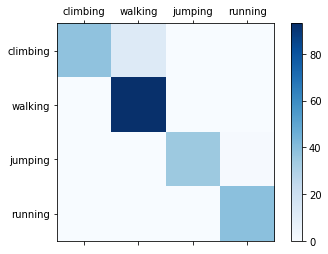

In [180]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([""] + TASKS)
ax.set_yticklabels([""] + TASKS)
# plt.matshow(cm, cmap=plt.cm.Blues)
# plt.colorbar()
# S)
plt.show()